In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import spectrogram

In [2]:
class Pipeline:

    distance = None
    angular_velocity = None
    saccade = None
    micro_saccade = None
    macro_saccade = None

    x_micro = None
    y_micro = None
    x_macro = None
    y_macro = None
    
    def __init__(self, t, x, y):
        self.t = t
        self.x = x
        self.y = y

    def run(self):
        self.__normalization()
        self.__dropping_outliers()
        self.__calculate_distance_to_origin()
        self.__calculate_angular_velocity()
        self.__filtering_angular_velocity()
        self.__filtering_distance()
        self.__calculate_saccade()
        self.__calculate_micro_macro()
        self.__mask_xy()
        # self.__plot_results()
        return self.__get_feature_vector()

    def __normalization(self):
        self.t = (self.t - self.t.min()) / (self.t.max() - self.t.min())
        self.x = (self.x - self.x.mean()) / self.x.std()
        self.y = (self.y - self.y.mean()) / self.y.std()

    def __dropping_outliers(self):
        Q1_x = self.x.quantile(0.25)
        Q3_x = self.x.quantile(0.75)
        IQR_x = Q3_x - Q1_x

        Q1_y = self.y.quantile(0.25)
        Q3_y = self.y.quantile(0.75)
        IQR_y = Q3_y - Q1_y

        lower_x, upper_x = Q1_x - 1.5 * IQR_x, Q3_x + 1.5 * IQR_x
        lower_y, upper_y = Q1_y - 1.5 * IQR_y, Q3_y + 1.5 * IQR_y

        mask_x = (self.x >= lower_x) & (self.x <= upper_x)
        mask_y = (self.y >= lower_y) & (self.y <= upper_y)
        
        mask = (self.x >= lower_x) & (self.x <= upper_x) & (self.y >= lower_y) & (self.y <= upper_y)

        self.x = self.x[mask]
        self.y = self.y[mask]
        self.t = self.t[mask]

        self.x = self.x.reset_index(drop=True)
        self.y = self.y.reset_index(drop=True)
        self.t = self.t.reset_index(drop=True)
    
    def __calculate_distance_to_origin(self):
        self.distance = np.sqrt(self.x**2 + self.y**2)


    def __calculate_angular_velocity(self):
        theta = np.arctan2(self.y, self.x)
        self.angular_velocity = theta.diff() / self.t.diff()

    
    def __filtering_angular_velocity(self):
    
        def lowpass_filter(data, cutoff=1000, fs=1/np.mean(np.diff(self.t)), order=4):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist

            if np.isnan(data).sum() > 0:
                print(f"Warning: Found {np.isnan(data).sum()} NaN values before filtering. Replacing with 0.")
                data = np.nan_to_num(data)  # Replace NaNs with 0
            
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            return filtfilt(b, a, data)
        
        self.angular_velocity = lowpass_filter(self.angular_velocity)
    
        self.angular_velocity = 2 * ((self.angular_velocity - self.angular_velocity.min()) / 
                                     (self.angular_velocity.max() - self.angular_velocity.min())) - 1
    
        self.angular_velocity = abs(self.angular_velocity)


    def __filtering_distance(self):

        def highpass_filter(data, cutoff=20000, fs=1/np.mean(np.diff(self.t)), order=4):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist 
            b, a = butter(order, normal_cutoff, btype='high', analog=False)
            return filtfilt(b, a, data)
            
        self.distance = highpass_filter(self.distance)
        
        self.distance = abs(self.distance)
        self.distance = (self.distance - self.distance.min()) / (self.distance.max() - self.distance.min())

    def __calculate_saccade(self):
        self.saccade = self.distance * self.angular_velocity

    
    def __calculate_micro_macro(self):
        self.micro_saccade = (self.saccade > 0.05).astype(int)
        self.macro_saccade = (self.saccade <= 0.05).astype(int)

    def __mask_xy(self):
        
        self.x_micro = self.x * self.micro_saccade
        self.y_micro = self.y * self.micro_saccade
        self.x_macro = self.x * self.macro_saccade
        self.y_macro = self.y * self.macro_saccade

    def __plot_results(self):
        fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

        axs[0].plot(self.t, self.x_micro, marker='o', linestyle='-', markersize=2, color='blue')
        axs[0].set_ylabel("Micro-Saccade (1=Yes, 0=No)")
        axs[0].set_title("x micro")
        axs[0].grid(True)
        
        axs[1].plot(self.t, self.y_micro, marker='o', linestyle='-', markersize=2, color='red')
        axs[1].set_xlabel("Time (Normalized)")
        axs[1].set_ylabel("Fixation (1=Yes, 0=No)")
        axs[1].set_title("y micro")
        axs[1].grid(True)

        axs[2].plot(self.t, self.x_macro, marker='o', linestyle='-', markersize=2, color='blue')
        axs[2].set_ylabel("Micro-Saccade (1=Yes, 0=No)")
        axs[2].set_title("x macro")
        axs[2].grid(True)
        
        axs[3].plot(self.t, self.y_macro, marker='o', linestyle='-', markersize=2, color='red')
        axs[3].set_xlabel("Time (Normalized)")
        axs[3].set_ylabel("Fixation (1=Yes, 0=No)")
        axs[3].set_title("y macro")
        axs[3].grid(True)
        
        plt.tight_layout()
        plt.show()

    def __extract_features(self, signal, fs=1):
        
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        skewness = skew(signal, nan_policy="omit")
        kurt = kurtosis(signal, nan_policy="omit")
        rms = np.sqrt(np.mean(signal**2))
        
        freqs, psd = welch(signal, fs=fs)
        
        dominant_freq = freqs[np.argmax(psd)] if len(freqs) > 0 else 0
        
        psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
        
        peak_freq = freqs[np.argmax(psd)] if len(freqs) > 0 else 0
    
        bandwidth = np.sqrt(np.sum(psd * (freqs - dominant_freq)**2) / np.sum(psd)) if np.sum(psd) > 0 else 0
        
        autocorr = np.correlate(signal - np.mean(signal), signal - np.mean(signal), mode="full")
        autocorr = autocorr[len(autocorr)//2:]  # Keep only positive lags
        zero_crossings = np.where(np.diff(np.sign(autocorr)))[0]
        autocorr_decay = zero_crossings[0] if len(zero_crossings) > 0 else len(autocorr)
    
        return [
            mean_val, std_val, skewness, kurt, rms, 
            dominant_freq, spectral_entropy, peak_freq, bandwidth, autocorr_decay
        ]

    def __get_feature_vector(self):
        
        x_micro_features = self.__extract_features(self.x_micro)
        y_micro_features = self.__extract_features(self.y_micro)
        x_macro_features = self.__extract_features(self.x_macro)
        y_macro_features = self.__extract_features(self.y_macro)
        
        feature_vector = x_micro_features + y_micro_features + x_macro_features + y_macro_features
        
        return feature_vector
    
                    

[np.float64(-0.0009751838659640738), np.float64(0.09251077685041711), np.float64(-7.536326558843293), np.float64(306.4824934023771), np.float64(0.09251591656055788), np.float64(0.0078125), np.float64(6.8379457665930214), np.float64(0.0078125), np.float64(0.23777407044710352), np.int64(14), np.float64(0.002008805836575158), np.float64(0.10996408678661017), np.float64(1.994941132435087), np.float64(169.13619783838175), np.float64(0.10998243352327769), np.float64(0.0078125), np.float64(6.881026312810992), np.float64(0.0078125), np.float64(0.24181687828806855), np.int64(17), np.float64(0.01281923408820157), np.float64(0.8813535720748709), np.float64(-0.29026022096620996), np.float64(0.005584256705278623), np.float64(0.8814467946346749), np.float64(0.00390625), np.float64(2.787884900842567), np.float64(0.00390625), np.float64(0.03838687526111183), np.int64(2145), np.float64(0.03979525838417117), np.float64(0.6896347241495591), np.float64(-0.5467639414457607), np.float64(0.05826600916022073)

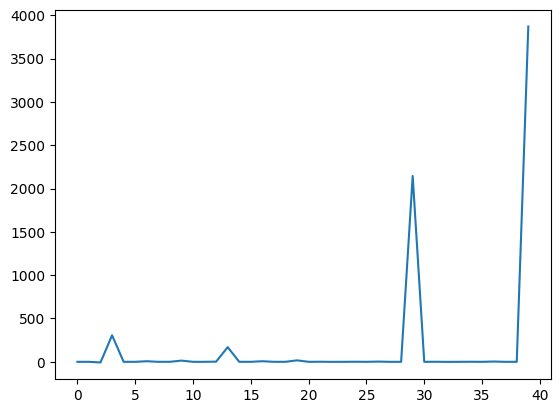

In [3]:
file_path = "../data/00/data.csv"
df = pd.read_csv(file_path)

selected_columns = ["t", "right_gaze_origin_position_in_hmd_coordinates_x", "right_gaze_origin_position_in_hmd_coordinates_y",
                    "left_gaze_origin_position_in_hmd_coordinates_x", "left_gaze_origin_position_in_hmd_coordinates_y"]
df = df[selected_columns]

df = df.rename(columns={
    "right_gaze_origin_position_in_hmd_coordinates_x": "x",
    "right_gaze_origin_position_in_hmd_coordinates_y": "y",
    "left_gaze_origin_position_in_hmd_coordinates_x": "x_left",
    "left_gaze_origin_position_in_hmd_coordinates_y": "y_left"
})

pipeline = Pipeline(df['t'], df['x'], df['y'])
features = pipeline.run()
print(features)

plt.plot(features)

In [4]:
file_path = "../data/00/data.csv"
df = pd.read_csv(file_path)

selected_columns = ["t", "right_gaze_origin_position_in_hmd_coordinates_x", "right_gaze_origin_position_in_hmd_coordinates_y",
                    "left_gaze_origin_position_in_hmd_coordinates_x", "left_gaze_origin_position_in_hmd_coordinates_y"]
df = df[selected_columns]

df = df.rename(columns={
    "right_gaze_origin_position_in_hmd_coordinates_x": "x",
    "right_gaze_origin_position_in_hmd_coordinates_y": "y",
    "left_gaze_origin_position_in_hmd_coordinates_x": "x_left",
    "left_gaze_origin_position_in_hmd_coordinates_y": "y_left"
})

In [5]:
df.head()

,t,x,y,x_left,y_left
0,1.581362e+15,-29.585846,1.740021,32.436142,5.695251
1,1.581362e+15,-29.591797,1.740555,32.421951,5.614624
2,1.581362e+15,-29.599228,1.711990,32.406448,5.580765
3,1.581362e+15,-29.606445,1.710693,32.386810,5.647583
4,1.581362e+15,-29.615341,1.769791,32.370270,5.730347


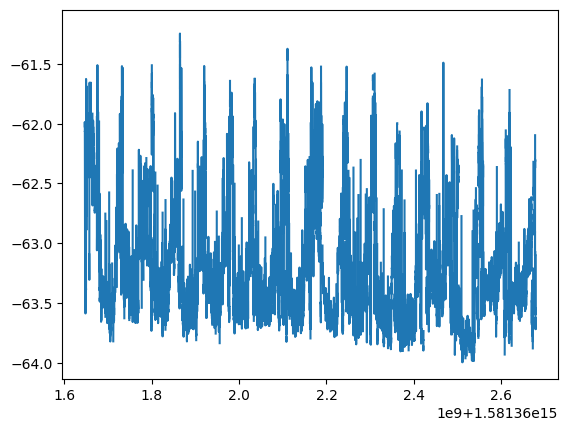

In [6]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

## Normalization

In [7]:
df["t"] = (df["t"] - df["t"].min()) / (df["t"].max() - df["t"].min())
df['x'] = 2 * ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min())) - 1
df['y'] = 2 * ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min())) - 1
df['x_left'] = 2 * ((df['x_left'] - df['x_left'].min()) / (df['x_left'].max() - df['x_left'].min())) - 1
df['y_left'] = 2 * ((df['y_left'] - df['y_left'].min()) / (df['y_left'].max() - df['y_left'].min())) - 1

In [8]:
df['x'].describe()

count    117446.000000
mean         -0.149223
std           0.280904
min          -1.000000
25%          -0.296482
50%          -0.129969
75%           0.025337
max           1.000000
Name: x, dtype: float64

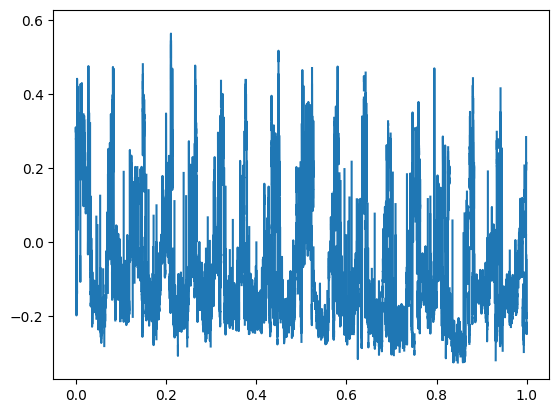

In [9]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

In [10]:
# df['x'] = abs(df['x'])
# df['y'] = abs(df['y'])
# df['x_left'] = abs(df['x_left'])
# df['y_left'] = abs(df['y_left'])

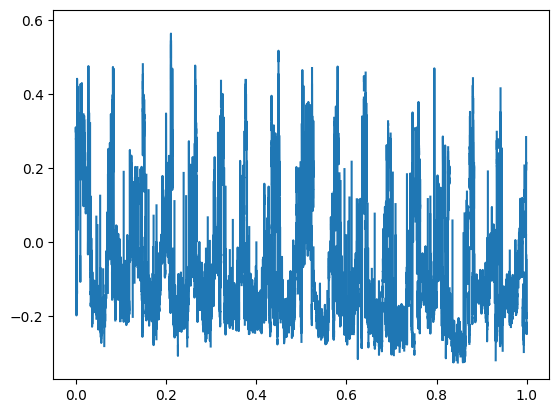

In [11]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

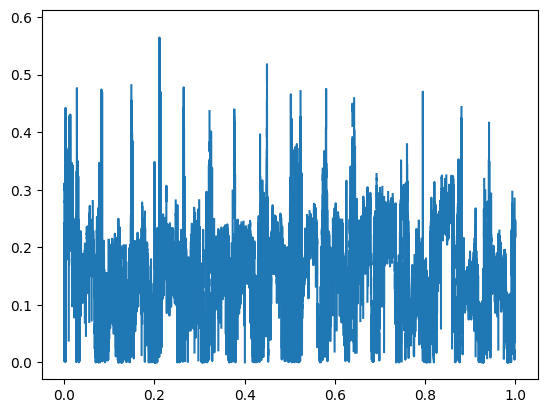

In [12]:
df['x_diff'] = abs(df['x'] - df['x_left'])

plt.plot(df['t'], df['x_diff'])

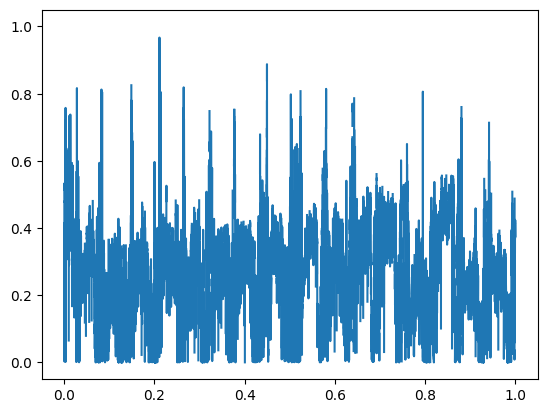

In [13]:
df["x_diff"] = (df["x_diff"] - df["x_diff"].min()) / (df["x_diff"].max() - df["x_diff"].min())

plt.plot(df['t'], df['x_diff'])

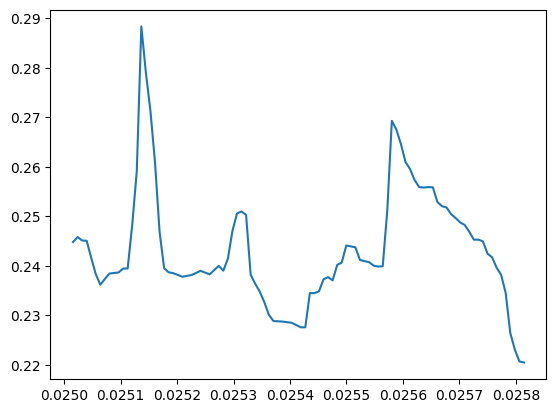

In [14]:
start = 3100 
end = start + 100

plt.plot(df['t'].iloc[start:end], df['x_diff'].iloc[start:end])

In [ ]:
start = 5500
end = start + 100

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("Y vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("Y vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Stretching signal

In [ ]:
power = 2
mean = df['x_diff'].mean()

df['x_diff'] = np.power(df['x_diff'], power)
df['x_diff'] = (df['x_diff'] / df['x_diff'].mean()) * mean

In [ ]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df['x_diff'] = df["x_diff"].fillna(0)

In [ ]:
def fft_column(col_name):
    sampling_rate = 1 / np.mean(np.diff(df["t"]))
    
    # Remove DC component (optional)
    signal = df[col_name] - np.mean(df[col_name])

    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    
    print(f"FFT Min: {np.min(np.abs(fft))}, Max: {np.max(np.abs(fft))}")
    
    # Check for NaNs or zeros
    if np.isnan(fft).any():
        print("⚠️ Warning: FFT contains NaNs!")
    if np.all(np.abs(fft) < 1e-10):
        print("⚠️ Warning: FFT has only zero values!")

    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    
    axs.plot(freqs[:len(freqs)//2], np.abs(fft[:len(fft)//2]))
    axs.set_ylabel("Magnitude")
    axs.set_xlabel("Frequency (Hz)")
    axs.set_title(f"Fourier Transform of {col_name} (Mean Removed)")
    axs.grid(True)
    
    plt.tight_layout()
    plt.show()


def spectogram_column(col_name):
    fs = 1 / np.mean(np.diff(df["t"]))  
    f, t, Sxx = spectrogram(df[col_name], fs=fs, nperseg=256, noverlap=128)
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label="Power/Frequency (dB/Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectrogram of Angular Velocity (theta_vel)")
    plt.show()

fft_column('x_diff')
spectogram_column('x_diff')

In [ ]:
def highpass_filter(data, cutoff=10000, fs=1/np.mean(np.diff(df["t"])), order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # Change to 'high'
    return filtfilt(b, a, data)

df["x_diff_filtered"] = highpass_filter(df["x_diff"])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot original angular velocity
axs[0].plot(df["t"], df["x_diff"], label="Original", color="blue", alpha=0.7)
axs[0].set_ylabel("Angular Velocity (rad/s)")
axs[0].set_title("Original Angular Velocity (theta_vel)")
axs[0].grid(True)

# Plot filtered angular velocity
axs[1].plot(df["t"], df["x_diff_filtered"], label="Filtered (>1000 rad/s)", color="red", linewidth=2)
axs[1].set_xlabel("Time (Normalized)")
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("Filtered Angular Velocity (theta_vel)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
fft_column('x_diff_filtered')
spectogram_column('x_diff_filtered')

In [ ]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff_filtered"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df['x_diff_filtered'] = (df['x_diff_filtered'] - np.min(df['x_diff_filtered'])) / (np.max(df['x_diff_filtered']) - np.min(df['x_diff_filtered']))

In [ ]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff_filtered"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def smooth_signal(data, sigma=5):
    """Applies Gaussian smoothing to remove noise while preserving peaks."""
    return gaussian_filter1d(data, sigma=sigma)

df["x_diff_smoothed"] = smooth_signal(df["x_diff_filtered"], sigma=2)

# Plot original and smoothed signal
plt.figure(figsize=(10, 5))
plt.plot(df["t"], df["x_diff_filtered"], label="Original Filtered Signal", alpha=0.6)
plt.plot(df["t"], df["x_diff_smoothed"], label="Smoothed Signal", color="red")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.title("Smoothed Signal with Gaussian Filter")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.signal import convolve

# Define edge-detection kernel (difference kernel)
difference_kernel = np.array([-1,-1, 0, 1,1])  # Detects changes in the signal

# Apply convolution to detect peaks
df["x_diff_peaks"] = convolve(df["x_diff_smoothed"], difference_kernel, mode="same")

# Plot the peaks detected
plt.figure(figsize=(10, 5))
plt.plot(df["t"], df["x_diff_smoothed"], label="Original Signal", alpha=0.6)
plt.plot(df["t"], df["x_diff_peaks"], label="Peak-Enhanced Signal", color="red")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.title("Peak Detection Using Convolution")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], abs(df["x_diff_peaks"]).iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df['x_diff_peaks'] = abs(df['x_diff_peaks'])
plt.plot(df['x_diff_peaks'])

In [ ]:
fft_column('x_diff_peaks')
spectogram_column('x_diff_peaks')

In [ ]:
def lowpass_filter(data, cutoff=10000, fs=1/np.mean(np.diff(df["t"])), order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df["x_diff_peaks"] = lowpass_filter(df["x_diff_peaks"])

In [ ]:
fft_column('x_diff_peaks')
spectogram_column('x_diff_peaks')

In [ ]:
df['x_diff_peaks'] = abs(df['x_diff_peaks'])
plt.plot(df['x_diff_peaks'])

In [ ]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], abs(df["x_diff_peaks"]).iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()